In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [8]:
import numpy as np
import cupy as cp

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

import datetime
import time

from PIL import Image

from sscPimega import misc

import random
random.seed(0)

from ptycho_functions import *


def PIE_update_func(obj,probe,s_o=1,s_p=1,r_o=0.1,r_p=0.1,algo='rPIE'):

    """ 
    s: step constant
    r: regularization constant
    """
    
    _obj_ = obj[py:py+offset[0],px:px+offset[1]]
    
    if algo == 'rPIE':
        _obj_ = _obj_ + s_o*difference*probe.conj() / ( (1-r_o)*np.abs(probe)**2+r_o*(np.abs(probe)**2).max()) # rPIE object update
        probe = probe + s_p*difference*_obj_.conj() / ( (1-r_p)*np.abs(_obj_)**2+r_p*(np.abs(_obj_)**2).max()) # rPIE probe update
    elif algo == 'ePIE':
        pass #TODO
        
    obj[py:py+offset[0],px:px+offset[1]] = _obj_

    return obj, probe

def denominator_obj(obj,reg_o,algo='rPIE'):
    
    power = np.abs(obj)**2
    
    if algo == 'rPIE':
        denominator = (1-reg_o)*power+ reg_o*np.max(power)
    elif algo == 'ePIE':
        pass
    
    return denominator  

def denominator_probe(wavefront_modes,reg_p,algo='rPIE'):
    
    total_probe_power = np.zeros_like(wavefront_modes[0])
    for mode in wavefront_modes:
        total_probe_power += np.abs(mode)**2    
        
    if algo == 'rPIE':
        denominator = (1-reg_p)*total_probe_power+ reg_p*np.max(total_probe_power)
    elif algo == 'ePIE':
        pass
    
    return denominator  

def PIE_update_func_multiprobe(obj,probe_modes,wavefront_diff_modes,s_o=1,s_p=1,r_o=0.1,r_p=0.1,algo='rPIE'):

    """ 
    s: step constant
    r: regularization constant
    """
    
    # Pre-calculating to avoid repeated operations
    denominator = denominator_probe(probe_modes,r_p,algo)
    obj_conj = obj.conj()
    
    if algo == 'rPIE':
        
        for m, mode in enumerate(probe_modes):
            probe_modes[m] = probe_modes[m] + s_p * obj_conj*wavefront_diff_modes[m] / denominator # probe update
        
        obj = obj + s_o * np.sum(probe_modes.conj()*wavefront_diff_modes,axis=0) / denominator_obj(obj,r_o,algo) # object update
        
    return obj, probe_modes


def Fspace_update_multiprobe(wavefront_modes,DP_magnitude):
    
    total_wave_intensity = np.zeros_like(wavefront_modes[0])
    for mode in wavefront_modes:
        total_wave_intensity += np.abs(mode)**2
        # print(np.max(total_wave_intensity))
    total_wave_intensity = np.sqrt(total_wave_intensity)
    
    wavefront_diff_modes = np.zeros_like(wavefront_modes,dtype=complex)
    for m, mode in enumerate(wavefront_modes): #TODO: worth updating in parallel?
        #TODO: update only where difpad is valid
        wavefront_diff_modes[m] = DP_magnitude*mode/total_wave_intensity - mode
    
    return wavefront_diff_modes
    
def propagate_farfield_multiprobe(wavefront_modes,backpropagate=False):
    
    if backpropagate == False:
        for m, mode in enumerate(wavefront_modes): #TODO: worth propagating in parallel?
            wavefront_modes[m] = np.fft.fftshift(np.fft.fft2(wavefront_modes[m]))
    else:
        for m, mode in enumerate(wavefront_modes):
            wavefront_modes[m] = np.fft.fftshift(np.fft.ifft2(wavefront_modes[m]))
    
    return wavefront_modes


def update_exit_wave_multiprobe(wavefront_modes,DP_magnitude):
    wavefront_modes = propagate_farfield_multiprobe(wavefront_modes)
    
    wavefront_modes = Fspace_update_multiprobe(wavefront_modes,DP_magnitude)
    
    wavefront_modes = propagate_farfield_multiprobe(wavefront_modes,backpropagate=True)

    return wavefront_modes

def PIE_multiprobe_loop(diffractions_patterns, positions, iterations, parameters, model_obj, n_of_modes = 1, object_guess=None, probe_guess=None, use_momentum = True):
    t0 = time.perf_counter()
    print("Starting multiprobe PIE algorithm...")
    
    r_o = parameters["regularization_object"]
    r_p = parameters["regularization_probe"]
    s_o = parameters["step_object"]
    s_p = parameters["step_probe"]
    f_o = parameters["friction_object"]
    f_p = parameters["friction_probe"]
    m_counter_limit = parameters["momentum_counter"]
    
    offset = probe_guess.shape
    obj = np.ones((n_of_modes,object_guess.shape[0],object_guess.shape[1]),dtype=complex)
    obj[:] = object_guess
    
    if probe_guess is not None:
        probe_modes = np.ones((n_of_modes,probe_guess.shape[0],probe_guess.shape[1]),dtype=complex)
    else:
        probe_modes = probe_guess
    
    probe_velocity = np.zeros_like(probe_modes,dtype=complex)
    obj_velocity   = np.zeros_like(obj,dtype=complex)

    momentum_counter = 0
    error_list = []
    for i in range(iterations):

        if i%20 == 0 : print(f'\tIteration {i}/{iterations}')
        
        temporary_obj, temporary_probe = obj.copy(), probe_modes.copy()
        
        for j in np.random.permutation(len(diffractions_patterns)):  
            
            px, py = positions[:,1][j],  positions[:,0][j]
            DP_magnitude = np.sqrt(diffractions_patterns[j])
            
            obj_box = obj[:,py:py+offset[0],px:px+offset[1]]
            
            """ Wavefront at object exit plane """
            wavefront_modes = obj_box*probe_modes

            """ Propagate + Update + Backpropagate """
            wavefront_modes = update_exit_wave_multiprobe(wavefront_modes,DP_magnitude)

            single_obj_box, probe_modes = PIE_update_func_multiprobe(obj_box[0],probe_modes,wavefront_modes,s_o,s_p,r_o,r_p)

            if use_momentum == True: # momentum addition
                momentum_counter,obj_velocity,probe_velocity,temporary_obj,temporary_probe,single_obj_box,probe_modes = momentum_addition(momentum_counter,m_counter_limit,probe_velocity,obj_velocity,temporary_obj,temporary_probe,single_obj_box, probe_modes,f_o,f_p)

            obj[:,py:py+offset[0],px:px+offset[1]] = single_obj_box

        error_list.append(calculate_recon_error(model_obj,obj)) #absolute error

    dt = time.perf_counter() - t0
    print(f"PIE algorithm ended in {dt} seconds")
    
    return obj, probe_modes, error_list, dt

def momentum_addition_multiprobe(momentum_counter,m_counter_limit,probe_velocity,obj_velocity,O_aux,P_aux,obj,probe,friction_object,friction_probe,momentum_type=""):
    
    momentum_counter += 1
    if momentum_type == "Nesterov": # equation 21
        
        damping_obj = friction_object # use same values for now
        damping_probe = friction_probe
        
        if momentum_counter == m_counter_limit : # T parameter in mPIE paper https://doi.org/10.1364/OPTICA.4.000736
            probe_velocity = friction_probe*probe_velocity + (probe - P_aux) # equation 19 in the paper
            obj_velocity   = friction_object*obj_velocity  + (obj - O_aux)  

        obj = obj + damping_obj*obj_velocity
        probe = probe + damping_probe*probe_velocity 

        if momentum_counter == m_counter_limit : 
            O_aux = obj
            P_aux = probe            
            momentum_counter = 0
            
    else: # equation 20     
        if momentum_counter == m_counter_limit : # T parameter in mPIE paper https://doi.org/10.1364/OPTICA.4.000736

            probe_velocity = friction_probe*probe_velocity + (probe - P_aux) # equation 19 in the paper
            obj_velocity   = friction_object*obj_velocity  + (obj - O_aux)  

            obj = O_aux + obj_velocity
            probe = P_aux + probe_velocity 

            O_aux = obj
            P_aux = probe            
            momentum_counter = 0
    
    return momentum_counter,obj_velocity,probe_velocity,O_aux,P_aux,obj,probe


def plot_results(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time):
    colormap = 'jet'    
    figure, ax = plt.subplots(3,5,dpi=150,figsize=(10,6))
    count = -1
    for i,ax0 in enumerate(ax.reshape(-1)):
        count += 1
        if count == 5: 
            ax0.grid()
            continue
        ax0.set_yticks([])
        ax0.set_xticks([])
    ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap=colormap)
    ax[0,0].set_title("Sum of difpads")
    ax[0,1].imshow(np.abs(model_obj),cmap=colormap)
    ax[0,1].set_title("Magnitude")
    ax[0,2].imshow(np.angle(model_obj),cmap=colormap)
    ax[0,2].set_title("Phase")
    ax[0,3].imshow(np.abs(probe_guess),cmap=colormap)
    ax[0,3].set_title("Magnitude")
    ax[0,4].imshow(np.angle(probe_guess),cmap=colormap)
    ax[0,4].set_title("Phase")
    ax[1,0].plot(RAAR_error,'.-',label='RAAR')
    ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
    ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap)
    ax[1,3].imshow(np.abs(RAAR_probe),cmap=colormap)
    ax[1,4].imshow(np.angle(RAAR_probe),cmap=colormap)
    ax[0,0].set_ylabel('Model')
    ax[1,0].set_ylabel('RAAR')
    ax[2,0].set_ylabel('mPIE')
    ax[1,0].plot(PIE_error,'.-',label='PIE')
    ax[2,1].imshow(np.abs(PIE_obj),cmap=colormap)
    crop = 25
    ax[2,0].imshow(np.abs(PIE_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[2,2].imshow(np.angle(PIE_obj),cmap=colormap)
    ax[2,3].imshow(np.abs(PIE_probe),cmap=colormap)
    ax[2,4].imshow(np.angle(PIE_probe),cmap=colormap)
    ax[1,0].legend()
    figure.tight_layout()
    
def plot_results2(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time):
    colormap = 'jet'    
    figure, ax = plt.subplots(4,5,dpi=150,figsize=(15,10))
    count = -1
    for i,ax0 in enumerate(ax.reshape(-1)):
        count += 1
        if count == 5: 
            ax0.grid()
            continue
        ax0.set_yticks([])
        ax0.set_xticks([])
    ax[0,0].imshow(np.sum(difpads,axis=0),norm=LogNorm(),cmap=colormap)
    ax[0,0].set_title("Sum of difpads")
    ax[0,1].imshow(np.abs(model_obj),cmap=colormap)
    ax[0,1].set_title("Magnitude")
    ax[0,2].imshow(np.angle(model_obj),cmap=colormap)
    ax[0,2].set_title("Phase")
    ax[0,3].imshow(np.abs(probe_guess),cmap=colormap)
    ax[0,3].set_title("Magnitude")
    ax[0,4].imshow(np.angle(probe_guess),cmap=colormap)
    ax[0,4].set_title("Phase")
    ax[1,0].plot(RAAR_error,'.-',label='RAAR')
    ax[1,1].imshow(np.abs(RAAR_obj),cmap=colormap)
    ax[1,2].imshow(np.angle(RAAR_obj),cmap=colormap)
    ax[1,3].imshow(np.abs(RAAR_probe),cmap=colormap)
    ax[1,4].imshow(np.angle(RAAR_probe),cmap=colormap)
    ax[0,0].set_ylabel('Model')
    ax[1,0].set_ylabel('RAAR')
    ax[2,0].set_ylabel('mPIE')
    ax[1,0].plot(PIE_error,'.-',label='PIE')
    ax[2,1].imshow(np.abs(PIE_obj),cmap=colormap)
    crop = 25
    ax[2,0].imshow(np.abs(PIE_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[2,2].imshow(np.angle(PIE_obj),cmap=colormap)
    ax[2,3].imshow(np.abs(PIE_probe),cmap=colormap)
    ax[2,4].imshow(np.angle(PIE_probe),cmap=colormap)

    
    ax[1,0].plot(PIE2_error,'--',label='PIE-multi')
    ax[3,0].imshow(np.abs(PIE2_obj[crop:-crop,crop:-crop]),cmap=colormap)
    ax[3,1].imshow(np.abs(PIE2_obj),cmap=colormap)
    ax[3,2].imshow(np.angle(PIE2_obj),cmap=colormap)
    ax[3,3].imshow(np.abs(PIE2_probe),cmap=colormap)
    ax[3,4].imshow(np.angle(PIE2_probe),cmap=colormap)    

    ax[1,0].legend()
    figure.tight_layout()
    
def PIE_update_obj_and_probe(mPIE_params,difference,probe,obj,px,py,offset,use_rPIE_update_function=True):
    #TODO: update only where difpad is valid?
    alpha,beta,gamma_obj,gamma_probe,eta_obj,eta_probe,T_lim = mPIE_params

    if use_rPIE_update_function: # rPIE update function
        obj[py:py+offset[0],px:px+offset[1]] = obj[py:py+offset[0],px:px+offset[1]] + gamma_obj*difference*probe.conj()/ ( (1-alpha)*np.abs(probe)**2+alpha*(np.abs(probe)**2).max() )
        # P = P + gamma_probe*difference*obj[py:py+offset[0],px:px+offset[1]].conj()/ ( (1-beta)*np.abs(P)**2+beta*(np.abs(P)**2).max() )
        probe = probe + gamma_probe*difference*obj[py:py+offset[0],px:px+offset[1]].conj()/ ( (1-beta)*np.abs(obj[py:py+offset[0],px:px+offset[1]])**2+beta*(np.abs(obj[py:py+offset[0],px:px+offset[1]])**2).max() )
    else: #ePIE update function
        obj[py:py+offset[0],px:px+offset[1]] = obj[py:py+offset[0],px:px+offset[1]] + alpha*difference*probe.conj()/(np.abs(probe)**2).max()
        probe = probe + beta*difference*obj[py:py+offset[0],px:px+offset[1]].conj()/(np.abs(obj)**2).max()
    return obj, probe

def momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,eta_obj,eta_probe):
    T_counter += 1 
    if T_counter == T_lim : # T parameter in mPIE paper
        probeVelocity  = probeVelocity*eta_probe + (probe - P_aux)
        objVelocity = objVelocity*eta_obj  + (obj - O_aux)  
        obj = O_aux + objVelocity
        probe = P_aux + probeVelocity 

        O_aux = obj
        P_aux = probe            
        T_counter = 0
        # T_counter = T_lim - 1
    return T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe
    
def RAAR_loop(difpads,positions,obj,probe,RAAR_params,experiment_params, iterations,model):
    t0 = time.perf_counter()
    print("Starting RAAR...")
    
    beta, epsilon = RAAR_params
    dx, wavelength,distance = experiment_params 
    m,n = probe.shape
    exitWaves = np.zeros((len(positions),probe.shape[0],probe.shape[1]),dtype=complex)

    for index, pos in enumerate((positions)):
        posy, posx = pos[0], pos[1]
        reconBox = obj[posy:posy + m , posx:posx+n]
        exitWaves[index] = probe*reconBox

    error = []
    for iteration in range(0,iterations):

        if iteration%10 ==0 : print(f'\tIteration {iteration}/{iterations}')

        for index, pos in enumerate((positions)):
            posy, posx = pos[0], pos[1]
            reconBox = obj[posy:posy + m , posx:posx+n]
            waveToPropagate = 2*probe*reconBox-exitWaves[index]
            exitWaveNew = update_exit_wave(waveToPropagate,difpads[index],experiment_params,epsilon=epsilon)
            exitWaves[index] = beta*(exitWaves[index] + exitWaveNew) + (1-2*beta)*probe*reconBox

        probe = RAAR_update_probe(exitWaves, obj, probe.shape,positions, epsilon=epsilon)
        obj   = RAAR_update_object(exitWaves, probe, obj.shape, positions,epsilon=epsilon)

        error.append(calculate_recon_error(model,obj)) #absolute error
    return obj, probe, error, time.perf_counter()-t0

def mPIE_loop(difpads, positions,object_guess,probe_guess, mPIE_params,experiment_params, iterations,model_obj):
    t0 = time.perf_counter()
    print("Starting PIE...")
    
    mPIE = True
    use_rPIE_update_function = True
    
    _,_,_,_,eta_obj,eta_probe,T_lim = mPIE_params
    
    offset = probe_guess.shape
    probeVelocity = 0
    objVelocity = 0
    T_counter = 0

    # difpads = np.asarray(difpads)
    # obj = np.asarray(object_guess)
    # probe = np.asarray(probe_guess)
    obj = object_guess
    probe = probe_guess
    
    error_list = []
    for j in range(iterations):

        if j%10 ==0 : print(f'\tIteration {j}/{iterations}')
        error, O_aux, P_aux = 0, obj+0, probe+0
        for i in np.random.permutation(len(difpads)):  
        # for i in range(len(difpads)):  
            
            px, py = positions[:,1][i],  positions[:,0][i]
            measurement = difpads[i]
            
            """ Exit wavefiled """
            exitWave = obj[py:py+offset[0],px:px+offset[1]]*probe

            """ Propagate + Update + Backpropagate """
            exitWaveNew = update_exit_wave(exitWave,measurement,experiment_params,epsilon=0.01)
            
            difference = exitWaveNew - exitWave
            
            obj, probe = PIE_update_obj_and_probe(mPIE_params,difference,probe,obj,px,py,offset,use_rPIE_update_function)
            
            if mPIE == True: # momentum addition
                T_counter,objVelocity,probeVelocity,O_aux,P_aux,obj,probe = momentum_addition(T_counter,T_lim,probeVelocity,objVelocity,O_aux,P_aux,obj, probe,eta_obj,eta_probe)

                
        error_list.append(calculate_recon_error(model_obj,obj)) #absolute error
            
        # if j%2 == 0: # Print iteration
        #     figure, subplot = plt.subplots(1,2)
        #     subplot[0].imshow(np.abs(obj.get()),cmap=colormap)
        #     subplot[1].imshow(np.abs(probe.get()),cmap=colormap)
        #     subplot[0].set_title('Object')
        #     subplot[1].set_title('Probe')
        #     figure.suptitle(f'Iteration #{j}')
        #     plt.show()
        #     plt.close()

    # probe = probe.get() # get from cupy to numpy
    # obj = obj.get()

    return obj, probe, error_list, time.perf_counter() - t0

In [ ]:
""" MAIN CODE """
    
difpads, positions, model_obj, model_probe = get_simulated_data(random_positions=False)
probe_guess = model_probe*np.exp(-1j*np.random.rand(*model_probe.shape))
obj_guess = np.ones_like(model_obj) # constant object
obj_guess = np.random.rand(model_obj.shape[0],model_obj.shape[1])+1j

""" Experiment Parameters """
position_step = np.max([positions[i]-positions[i-1] for i in range(1,len(positions))])*1e-6
distance = 30  # meters
energy = 10    # keV
n_pixels = 3072
pixel_size = 55.13e-6  # meters
c_speed = 299792458    # Velocity of Light [m/s]
planck  = 4.135667662E-18  # Plank constant [keV*s]
wavelength = c_speed * planck / energy
dx = wavelength*distance/(n_pixels*pixel_size)
experiment_params = dx, wavelength,distance
oversampling_ratio = wavelength*distance/(position_step*pixel_size)
print('Object pixel size:',dx)
print("Oversampling: ",oversampling_ratio)

iterations = 100

""" RAAR """
beta = 0.995
epsilon = 0.01
RAAR_params = (beta,epsilon)
RAAR_obj, RAAR_probe, RAAR_error, RAAR_time = RAAR_loop(difpads,positions,obj_guess, probe_guess, RAAR_params,experiment_params, iterations,model_obj)


""" mPIE """
if 0: # suggested min from paper
    regularization_object, regularization_probe = 0.05, 0.5
    step_object, step_probe = 0.1, 0.2
    friction_object, friction_probe = 0.5, 0.75
    momentum_counter = 10
else: # suggested max from paper
    regularization_object, regularization_probe = 0.25, 5
    step_object, step_probe = 0.5, 1
    friction_object, friction_probe = 0.9, 0.99
    momentum_counter = 100 

mPIE_params = (regularization_object,regularization_probe,step_object,step_probe,friction_object,friction_probe,momentum_counter)
PIE_obj, PIE_probe, PIE_error, PIE_time = mPIE_loop(difpads, positions,obj_guess,probe_guess, mPIE_params, experiment_params, iterations, model_obj)

""" multiprobe mPIE """
mPIE_params = {}
mPIE_params["regularization_object"] = regularization_object
mPIE_params["regularization_probe"]  = regularization_probe
mPIE_params["step_object"]           = step_object
mPIE_params["step_probe"]            = step_probe
mPIE_params["friction_object"]       = friction_object
mPIE_params["friction_probe"]        = friction_probe
mPIE_params["momentum_counter"]      = momentum_counter
PIE2_obj, PIE2_probe, PIE2_error, PIE2_time  = PIE_multiprobe_loop(difpads, positions, iterations, mPIE_params, model_obj,n_of_modes = 1, object_guess=obj_guess, probe_guess=probe_guess, use_momentum = False)
PIE2_obj = PIE2_obj[0]
PIE2_probe = PIE2_probe[0]

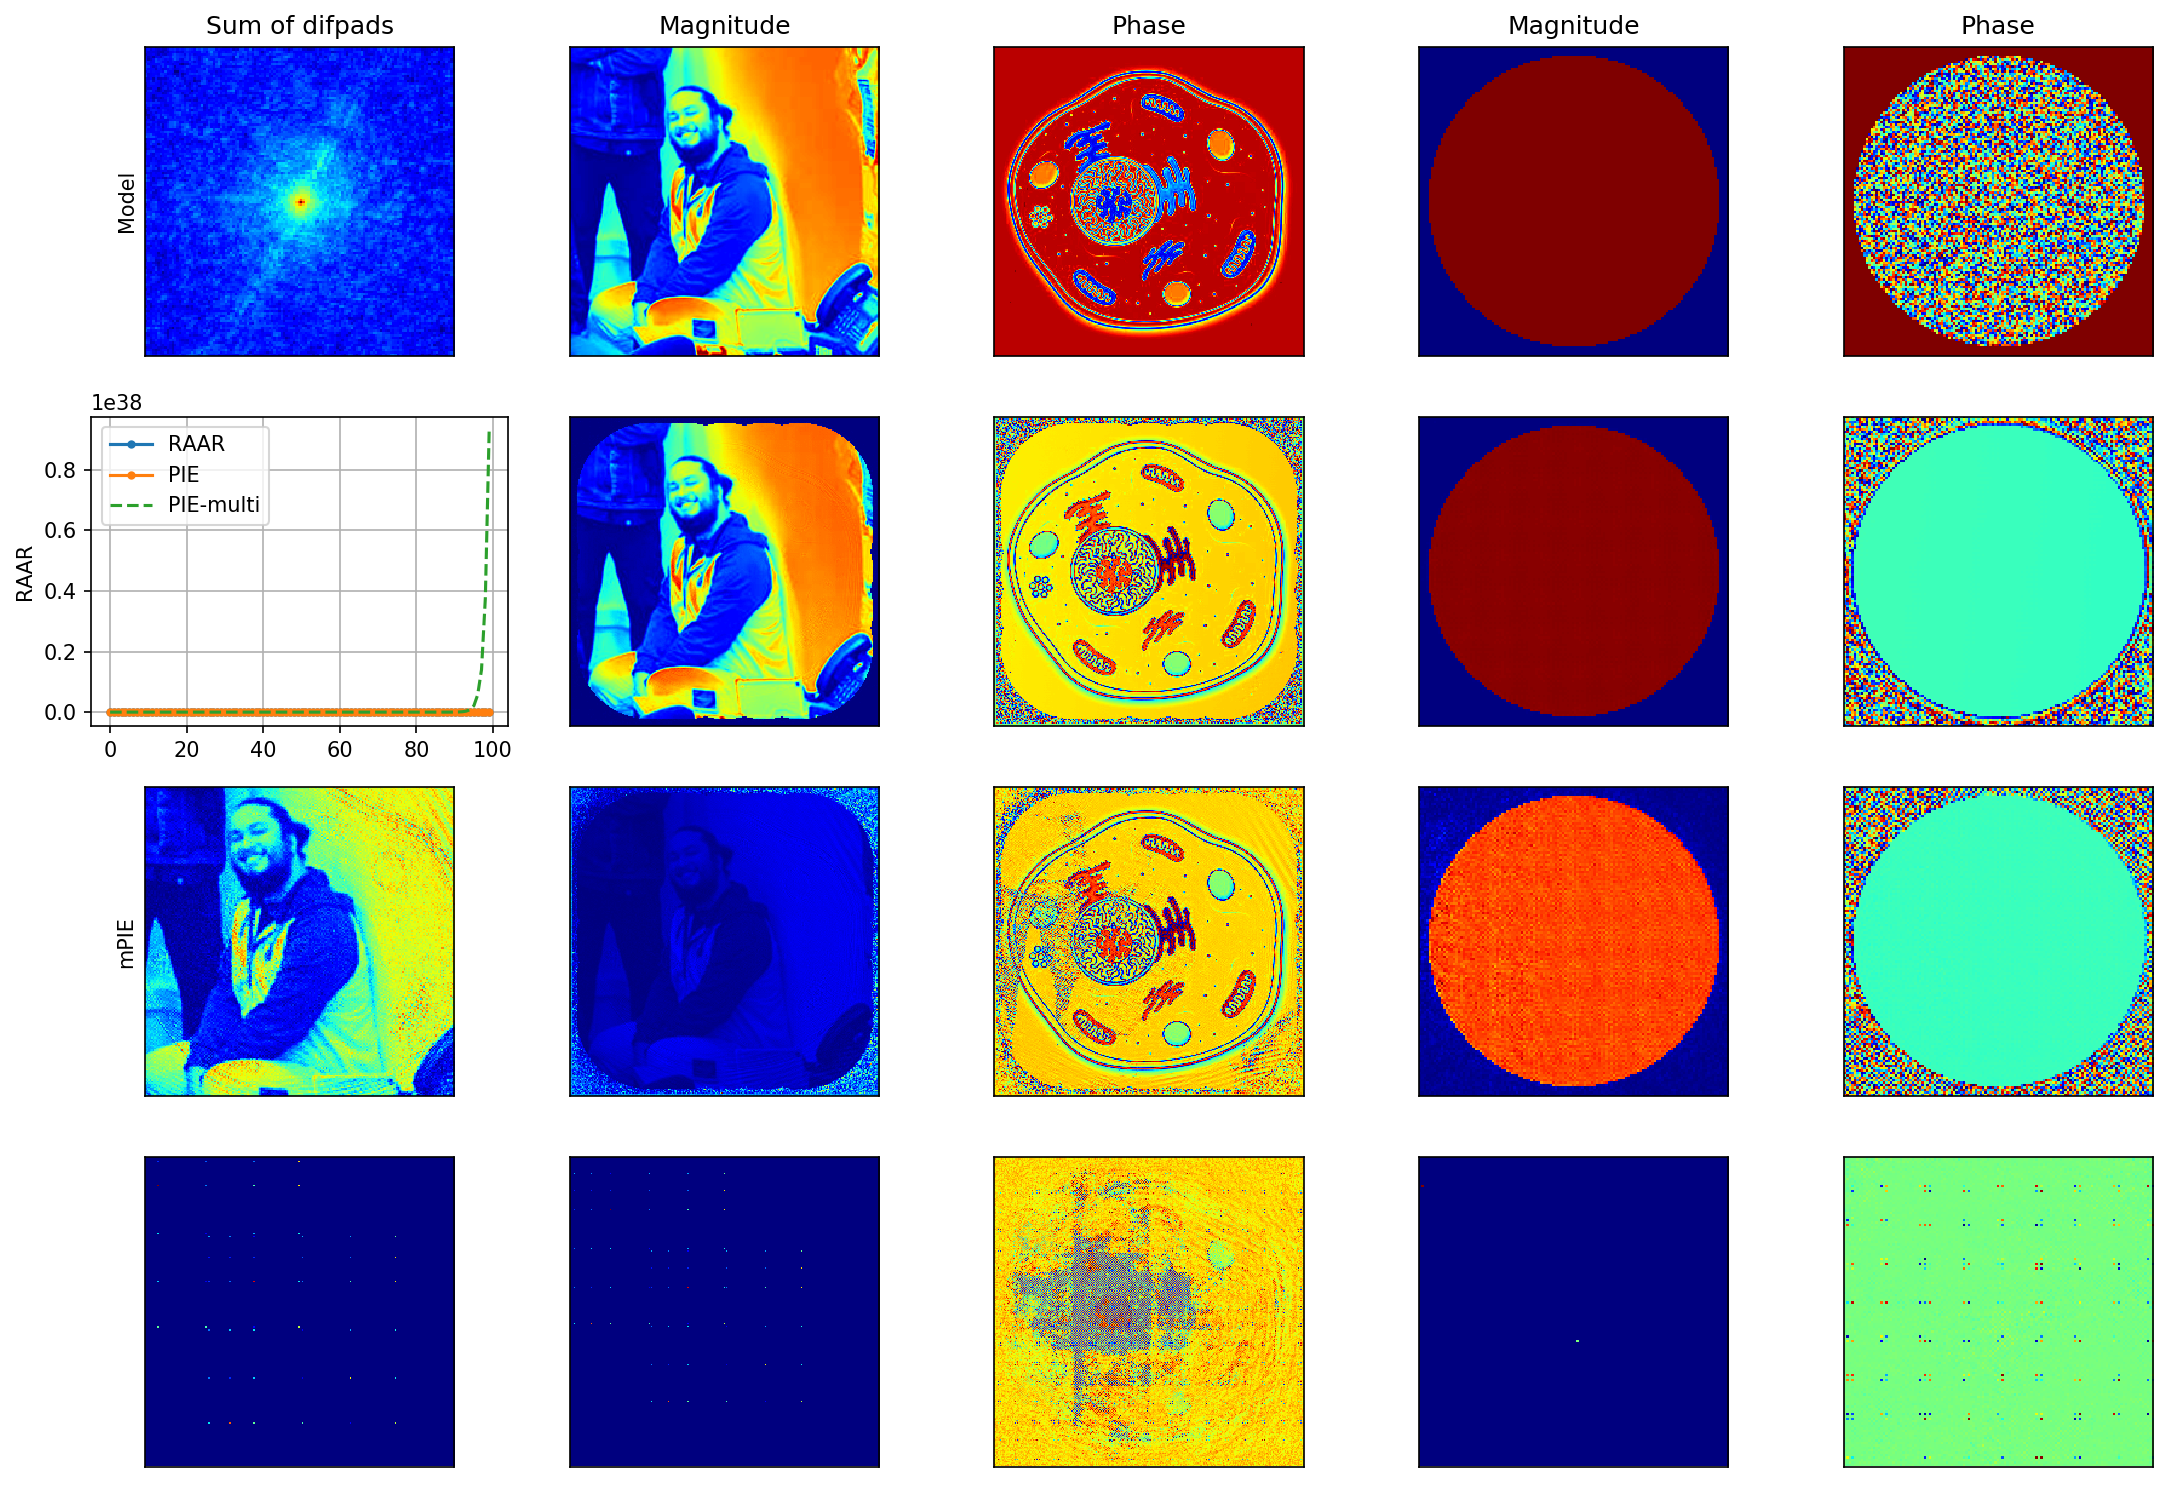

In [9]:
plot_results2(model_obj,probe_guess,RAAR_obj, RAAR_probe, RAAR_error, RAAR_time,PIE_obj, PIE_probe, PIE_error, PIE_time,PIE2_obj, PIE2_probe, PIE2_error, PIE2_time)